#  **DATA DRIFT DETECTION**
Machine Learning models are unique and usually optimized for very specific problems, but their performance may nevertheless vary over time.  
Team develops the model, tests it and everything works fine for some time. Then as time goes by, testing data is incorporated in the training set and new data come into production. One of the top reasons why performance of ML models decreases over time is caused by a drift in data.  
Data drift is described as a change in the distribution of data over time.  
This may occur in operational ML pipelines, when the drift occurs as the change in the distribution of the baseline data set used to train a particular model and the current, real-time production data. The distribution of the latter might be different because of any alteration in the real world: the **_stochastic process_** that generates the data in question has changed.  
A classical example of this is the presence of seasonality in data, but drifts can also be caused by extreme events (pandemics, for example..); what is important to remember is that drifts happens when the statistical properties of the underlying variables that predict an outcome change.  
Goal of this notebook is to explain two ways to run checks on your training and testing data to verify the presence of a data drift.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Choice of dataset
First, we import a dataset for our experiment: I choose the **_Credit Card Fraud dataset_** freely available [kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).  
This dataset contains transactions made by credit cards in September 2013 by European cardholders, and is usually used for fraud detection and unbalanced classes studies: it presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.  
The dataset contains only numerical input variables which are the result of a **_PCA transformation_**. Due to confidentiality issues, original authors cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.  
Now this dataset is very handy for our example because since the features come from PCA performed on real data, we do not (and can not) know anything about them. But we can still verify the presence of a drift whenever new data comes in.

In [158]:
df = pd.read_csv('/creditcard.csv')

We perform some very basic exploration of the dataset in our possession

In [157]:
df.shape

(284807, 30)

In [3]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [5]:
df.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

In [6]:
df = df.drop('Time', axis=1) # We are not interested in the variable 'Time' for this excercise, so just drop it

What is the percentage of frauds in this dataset? That is to say, what is how many frauds out of all the transactions in the dset are there?  
Remember that dset contains information for only two days.

In [7]:
print('Percentage of frauds in the dataset is ', np.round((np.sum(df.Class) / len(df))*100, 3), '% of total transactions')

Percentage of frauds in the dataset is  0.173 % of total transactions


## Original training and testing set ##  
Since this is a working example, we perform the original train-test splitting ourselves. Remember that ideally, testing in production should be **_newly acquired data_** that our model hasn't see previously. 

In [9]:
X_orig, y_orig = df.loc[:, df.columns != 'Class'], df['Class']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=1, stratify=y_orig) 
print(X_train_orig.shape, X_test_orig.shape, y_train_orig.shape, y_test_orig.shape) # making sure that train-test splitting happens with the same fraud pct

(199364, 29) (85443, 29) (199364,) (85443,)


In [10]:
print('Percentage of frauds in the train dset is ', np.round((np.sum(y_train_orig) / len(y_train_orig))*100, 3), '% of total transactions') #check
print('AND')
print('Percentage of frauds in the train dset is ', np.round((np.sum(y_test_orig) / len(y_test_orig))*100, 3), '% of total transactions')

Percentage of frauds in the train dset is  0.173 % of total transactions
AND
Percentage of frauds in the train dset is  0.173 % of total transactions


## Data Drift detection with **Random Forest** ##
We want to know wheter or not there's a drift between training and testing phase.  
In production, every now and then (may be on daily, weekly, monthly basis..) new data comes in: we want to discover if new data generates from the same stochastic process that generated "old" data (which is, of course, still in the training set!).  
How to do this? The answer is quite simple.  
We translate the question this way: is there a way a (simple) Machine Learning algorythm can distinguish between training and testing set in a deterministic way? If the answer is yes, then we may be having a data drift problem.  
Let's start by labelling with zeros observations from the original training set, while the original testing data will be labelled with 1

In [11]:
X_train_orig['Target'] = 0 
X_test_orig['Target'] = 1

We then join training and testing set and proceed to shuffle the new dataframe.  
The real Class value (fraud/not a fraud) is none of our business, because we really just want to check if the stochastic process that generates frauds is still the same between training and testing, therefore we do not care about the 'Class' feature in the original dataset. 

In [12]:
frames = [X_train_orig, X_test_orig]   
drifting_df = pd.concat(frames)
drifting_df = drifting_df.sample(frac=1).reset_index(drop=True)   # shuffling the new df
drifting_df.shape
drifting_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Target
0,-0.574501,1.117222,1.635889,2.855814,-0.369436,-0.180819,0.209807,0.228980,-0.703786,0.527349,...,0.047201,0.329075,-0.004759,0.718633,-0.267540,0.079824,-0.315484,-0.224792,12.52,1
1,0.297272,-3.596179,-3.491096,0.429110,-0.885160,-1.408148,1.884916,-0.914348,-1.192692,0.580871,...,0.506746,-0.204007,-0.966447,0.097492,0.099141,0.916954,-0.312858,0.081973,1018.00,0
2,-1.708808,0.777698,1.059110,-0.455618,0.345712,-0.893250,1.396244,-0.381813,-0.329686,-0.172026,...,-0.403242,-0.748797,0.336336,0.383539,-0.370202,-0.292606,-0.754060,-0.463178,69.90,0
3,-1.047911,0.264798,2.882793,1.050493,-1.754437,1.013074,-1.216518,0.993989,-0.289283,0.066573,...,-0.392708,-0.197803,-0.109727,0.396181,0.181980,-0.065889,0.328321,0.089068,12.00,0
4,1.249711,-0.694850,0.000151,-0.444425,-0.810558,-0.589118,-0.246620,-0.154379,-0.756298,0.562567,...,-0.390296,-0.630127,-0.022713,0.114441,0.327275,1.116745,-0.065491,0.003907,64.99,0


Next step is to train a Random Forest Model on the newly obtained dataset, keeping in mind that our target is now the 'Target' variable, that tells us whether or not the observation comes from the **_original_** training and testing set.  
Clearly, we start from random splitting.. 

In [13]:
X, y = drifting_df.loc[:, drifting_df.columns != 'Target'], drifting_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(199364, 29) (85443, 29) (199364,) (85443,)


In [14]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Now, let's stop and think about what we want this Random Forest Classifier to do.  
Theoretically, if there is no drift in our data, if there is no deterministic process that generates data, RF Classifier shouldn't do better than the toss of a coin, which means that _Accuracy should be around 0.5_.  
If that isn't the case, we should be worried, because something in the stochastic process from which we have drawn the original training and testing set is not stochastic at all: the process changed inbetween the moment we collected the original training set and the moment new data (the original testing set) came into our pipeline.

In [15]:
skl.metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

0.6999988296291094

There seem to be a problem: how can the RF classifier have an accuracy score of nearly 70% if the split is random and it has not been told whether an observation was in the original training or testing set?  
One way to answer this question might be to gather **_feature importances_**: usually, this is used to explain to an audience what are the most informative features in the decision trees that build the Random Forest ensemble, but here we use this method to understand what might be the features whose generative process changed the most. 

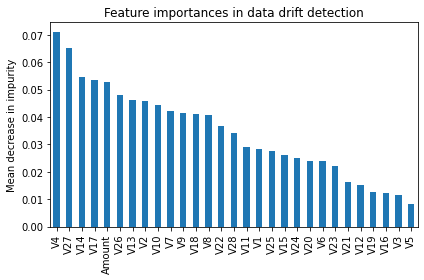

In [16]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train.columns)
forest_importances.sort_values(axis=0, ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances in data drift detection")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We now know what might be the features that changed the most their behaviour between training and testing period: of course, it will be the decision of the Data Scientist if and when to investigate further on the data drift theme. Said decision should be based on domain knowledge of data.

## **_Kolmogorov-Smirnov Test_**
A very efficient way to determine whether two samples are significantly different from one another is the Kolmogorov-Smirnov test: KS statistic quantifies distance between the empirical distribution functions of two samples, and it does so detecting in-sample variance. This is particularly useful in our case, because we are interested in knowing if data in the training and testing set originates from different stochastic processes, that is to say if we are looking into a data drift problem. Of course, we want to check this for **EVERY feature** in our data.  
Now, there is a function in the _stats_ package, called **_ks_2samp_**, that does exactly that, and takes two _np.arrays_ (in our case, a pair of the same feature from training and testing set) as an argument. This might be a problem, because our dataset could have tenths, hundres of features. We need to write a couple functions to avoid doing this manually. That can easily be done with a combination of data wrangling in _pandas_ and a _for loop_.   

## Warning ##
Please note that KS test only works on variables which distribution is **_continuos_**. We only have one non-continuos feature in our dataset, so we can just as well ignore it, but if you have multiple continuos features in your data might actually be a good idea to rewrite the for loop to run only for continuos variables. 

In [153]:
def ks_test_dd(feat1:pd.Series, feat2:pd.Series):
# performs Kolmogorov-Smirnov two-sided sample test on 2 features from different datasets #
# H0: two samples are drawn from the exact same distribution (the lower p-val, the higher chance distributions are different) #
# RETURNS: a df with stat (float) and p-value (float) #

    f1 = np.array(feat1.sample(n=10000))  #sampling the features and transforming them into arrays
    f2 = np.array(feat2.sample(n=10000))

    res = pd.DataFrame(sp.stats.ks_2samp(f1, f2, alternative="two-sided", mode="auto")) #running KS test on training and testing set features
    res = res.T
    res.columns = ['stat', 'p-value']

    return res 

In [154]:
def data_drift_ks(train:pd.DataFrame, test:pd.DataFrame):
# performs Kolmogorov-Smirnov two-sided sample test on each pair of features that are present both in training and testing data #
# H0: two samples are drawn from the exact same distribution (the lower p-val, the higher chance distributions are different) #
# RETURNS: a df with three columns: stat (float), p-value (float) and reject_H0 (bool) #

    feats = train.columns
    ks_res = pd.DataFrame(columns=['stat', 'p-value'])

    for v in feats:
        test_res = ks_test_dd(X_train_orig[v], X_test_orig[v])
        test_res.index = [str(v)]
        frames = [ks_res, test_res]
        ks_res = pd.concat(frames)

    ks_res['reject_H0'] = ks_res['p-value'] < 0.05 

    return ks_res 

In [156]:
data_drift_ks(X_train_orig, X_test_orig)

,stat,p-value,reject_H0
V1,0.0101,0.687549,False
V2,0.0122,0.446296,False
V3,0.0114,0.534270,False
V4,0.0087,0.843589,False
V5,0.0089,0.823267,False
V6,0.0167,0.122950,False
V7,0.0168,0.118902,False
V8,0.0080,0.906228,False
V9,0.0143,0.258234,False
V10,0.0096,0.746166,False


Success! As we can see from the output table, we don't reject the null hyphotesis for any feature in the dataset: remember that 'Target' was added by us and marks observation belonging to the original training or testing set: it does not come from a continuos distribution, so we just ignore that result. This brings us to assert that for each feature, there is no significant difference in its distribution across training and testing set, which is of course what we expected.

## Conclusion ##
We have briefly explored Data Drift theme and two ways to detect it in advance. The suggestion is to implement one or both checks, RF and KS test, in your ML pipeline, right after importing new data.

## Acknowledgements ##
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Machine Learning for Credit Card Fraud Detection - Practical Handbook